# Set Up

In [13]:
import sys
sys.path.append('../../Modules/')
sys.path.append('../../Modules/Processors from Prof')
from Packages import *
from My_CSV_processor import *
from Semantic_functions import *

# Import processors from Prof
from ipynb.fs.full.Utilities import *
from ipynb.fs.full.Json_Processor import *
from ipynb.fs.full.CSV_Processor import *

# Get Data

In [2]:
farel_bench = FarelBench_CSV_Processor_my('Farel-Bench', 'farel_bench.csv').convert_df()

In [ ]:
farel_bench['topic'].unique()

# WSD

In [3]:
text = build_text_from_questions(farel_bench)

In [4]:
wsd_farel_bench = auto_wsd(farel_bench)

In [5]:
wsd_farel_bench

{'Given': {'given.s.01': 1000},
 'family': {'syndicate.n.01': 1000},
 'relationships': {'relationship.n.03': 1000},
 'is': {'embody.v.02': 17750},
 'Anthony': {'antony.n.01': 189},
 'relationship': {'relationship.n.03': 1000},
 'correct': {'correct.v.08': 1000},
 'answer': {'solution.n.02': 2000},
 'selected': {'choose.v.01': 1000},
 'number': {'phone_number.n.01': 1000},
 'in': {'indium.n.01': 1000},
 'ANSWER': {'solution.n.02': 2000},
 'tag': {'tag.v.03': 1000},
 'example': {'model.n.07': 1000},
 '1': {'one.s.01': 1000},
 'John': {'whoremaster.n.01': 187},
 'Lawrence': {'lawrence.n.07': 153},
 'Joshua': {'joshua.n.02': 162},
 'Charlotte': {'charlotte.n.02': 158},
 'Wayne': {'wayne.n.02': 214},
 'Jean': {'denim.n.02': 205},
 'Arthur': {'arthur.n.02': 168},
 'Judith': {'judith.n.02': 171},
 'Benjamin': {'benzoin.n.01': 141},
 'Russell': {'russell.n.05': 195},
 'Charles': {'charles.n.09': 205},
 'Kelly': {'kelly.n.03': 143},
 'Bryan': {'bryan.n.02': 167},
 'Henry': {'henry.n.03': 223},


In [ ]:
len(wsd_farel_bench)

In [6]:
text = build_text_from_questions(farel_bench)

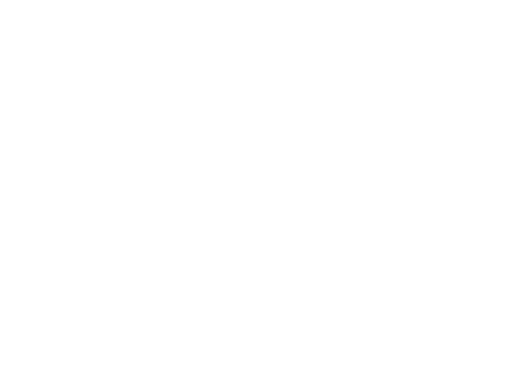

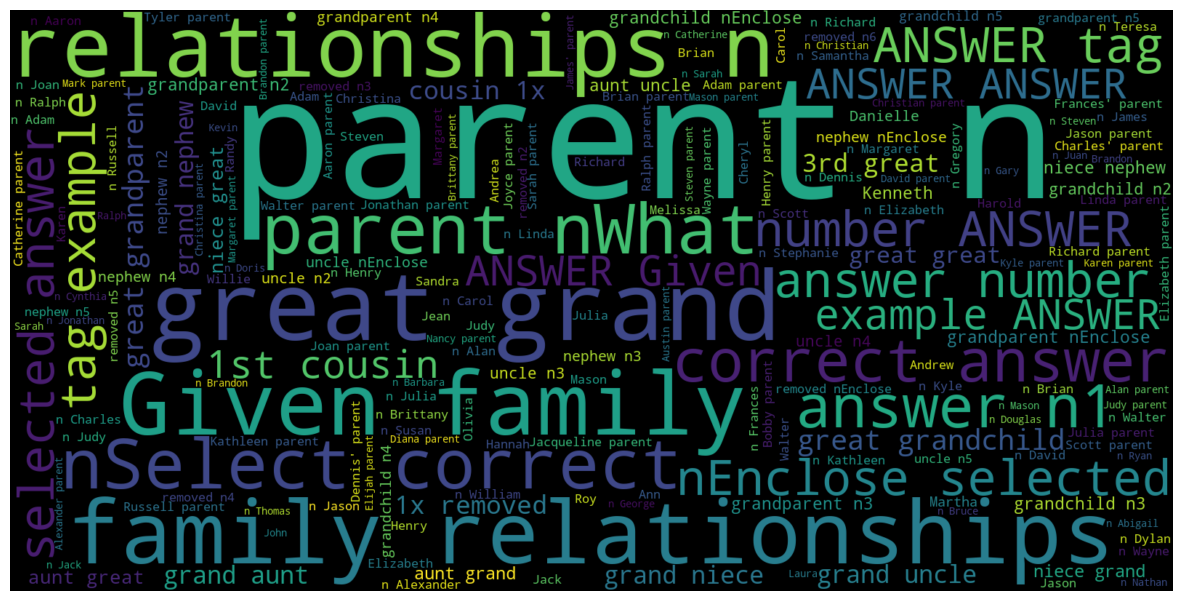

In [7]:
from Wordcloud import *
wc = Wordcloud()
wc.generate01(benchmark_name="sample", text=text, myStopwords = None, file_name = "wordcloud")

In [8]:
wsd_farel_bench['family']

{'syndicate.n.01': 1000}

In [ ]:
synset = wn.synset('syndicate.n.01')

# Retrieve the definition (meaning) of the synset
definition = synset.definition()

# Print the definition
print(definition)

In [9]:
len(wn.synsets("parent"))

3

In [10]:
wn.synsets("parent")

[Synset('parent.n.01'), Synset('parent.n.02'), Synset('rear.v.02')]

In [ ]:
farel_bench.loc[farel_bench['input'].str.contains('parent'),]

,topic,input,target
0,child,"Given the family relationships:\n* Ralph is Anthony's parent.\n* Albert is Ralph's parent.\nWhat is Anthony's relationship to Ralph?\nSelect the correct answer:\n1. Anthony is Ralph's child.\n2. Anthony is Ralph's parent.\nEnclose the selected answer number in the <ANSWER> tag, for example: <ANSWER>1</ANSWER>.",1
1,child,"Given the family relationships:\n* Jessica is John's parent.\n* John is Lawrence's parent.\nWhat is Lawrence's relationship to John?\nSelect the correct answer:\n1. Lawrence is John's parent.\n2. Lawrence is John's child.\nEnclose the selected answer number in the <ANSWER> tag, for example: <ANSWER>1</ANSWER>.",1
2,child,"Given the family relationships:\n* Raymond is William's parent.\n* Denise is Raymond's parent.\nWhat is William's relationship to Raymond?\nSelect the correct answer:\n1. William is Raymond's parent.\n2. William is Raymond's child.\nEnclose the selected answer number in the <ANSWER> tag, for example: <ANSWER>1</ANSWER>.",1
3,child,"Given the family relationships:\n* Samantha is Elijah's parent.\n* Elijah is Joshua's parent.\nWhat is Joshua's relationship to Elijah?\nSelect the correct answer:\n1. Joshua is Elijah's parent.\n2. Joshua is Elijah's child.\nEnclose the selected answer number in the <ANSWER> tag, for example: <ANSWER>1</ANSWER>.",1
4,child,"Given the family relationships:\n* Anna is Charlotte's parent.\n* Marie is Anna's parent.\nWhat is Charlotte's relationship to Anna?\nSelect the correct answer:\n1. Charlotte is Anna's parent.\n2. Charlotte is Anna's child.\nEnclose the selected answer number in the <ANSWER> tag, for example: <ANSWER>1</ANSWER>.",1
...,...,...,...
995,3rd great grandparent,Given the family relationships:\n* Karen is Kathryn's parent.\n* William is Jacqueline's parent.\n* Keith is Kelly's parent.\n* Linda is Andrea's parent.\n* Alexis is Walter's parent.\n* Ashley is William's parent.\n* Alexis is Kathleen's parent.\n* Randy is Victoria's parent.\n* Karen is Samantha's parent.\n* Victoria is Grace's parent.\n* Andrea is Keith's parent.\n* Walter is Roy's parent.\n* Walter is Randy's parent.\n* Grace is Shirley's parent.\n* Anthony is Linda's parent.\n* Samantha is Ashley's parent.\n* Roy is Scott's parent.\n* Kayla is Alexis' parent.\n* Kathryn is Anthony's parent.\n* Randy is Karen's parent.\nWhat is Kayla's relationship to Kathryn?\nSelect the correct answer:\n1. Kayla is Kathryn's great grand-niece or great grand-nephew.\n2. Kayla is Kathryn's 1st cousin 1x removed.\n3. Kayla is Kathryn's 3rd great grandchild.\n4. Kayla is Kathryn's 1st cousin 1x removed.\n5. Kayla is Kathryn's 3rd great grandparent.\n6. Kayla is Kathryn's great grand-aunt or great...,1
996,3rd great grandparent,Given the family relationships:\n* Ann is Juan's parent.\n* Austin is Judith's parent.\n* Steven is Cynthia's parent.\n* Amanda is Albert's parent.\n* Debra is Amanda's parent.\n* Keith is Steven's parent.\n* Raymond is Willie's parent.\n* Raymond is Terry's parent.\n* Judith is Gloria's parent.\n* Noah is Ann's parent.\n* Cynthia is Austin's parent.\n* Gabriel is Zachary's parent.\n* Terry is Diane's parent.\n* Samuel is Brandon's parent.\n* Brandon is Anthony's parent.\n* Willie is Gabriel's parent.\n* Diane is Debra's parent.\n* Ann is Samuel's parent.\n* Samuel is Raymond's parent.\n* Terry is Keith's parent.\nWhat is Noah's relationship to Keith?\nSelect the correct answer:\n1. Noah is Keith's great grand-aunt or great grand-uncle.\n2. Noah is Keith's 1st cousin 1x removed.\n3. Noah is Keith's 3rd great grandparent.\n4. Noah is Keith's 3rd great grandchild.\n5. Noah is Keith's 1st cousin 1x removed.\n6. Noah is Keith's great grand-niece or great grand-nephew.\nEnclose the sele...,1
997,3rd great grandparent,Given the family relationships:\n* Joan is Stephanie's parent.\n* Gabriel is Bobby's parent.\n* Jonathan is Patricia's parent.\n* Walter is Lori's parent.\n* Lori is Sharon's parent.\n* Lawrence is Kathryn's parent.\n* Daniel is Gabriel's parent.\

In [15]:
words = word_tokenize("Given the family relationships:\n* Ralph is Anthony's parent.\n* Albert is Ralph's parent.\nWhat is Anthony's relationship to Ralph?\nSelect the correct answer:\n1. Anthony is Ralph's child.\n2. Anthony is Ralph's parent.\nEnclose the selected answer number in the <ANSWER> tag, for example: <ANSWER>1</ANSWER>. ")

print(words)

['Given', 'the', 'family', 'relationships', ':', '*', 'Ralph', 'is', 'Anthony', "'s", 'parent', '.', '*', 'Albert', 'is', 'Ralph', "'s", 'parent', '.', 'What', 'is', 'Anthony', "'s", 'relationship', 'to', 'Ralph', '?', 'Select', 'the', 'correct', 'answer', ':', '1', '.', 'Anthony', 'is', 'Ralph', "'s", 'child', '.', '2', '.', 'Anthony', 'is', 'Ralph', "'s", 'parent', '.', 'Enclose', 'the', 'selected', 'answer', 'number', 'in', 'the', '<', 'ANSWER', '>', 'tag', ',', 'for', 'example', ':', '<', 'ANSWER', '>', '1', '<', '/ANSWER', '>', '.']


In [ ]:
ambiguous_words = [word for word in words if len(wn.synsets(word)) > 1]

print(ambiguous_words)

['Given', 'family', 'relationships', 'is', 'Anthony', 'parent', 'is', 'parent', 'is', 'Anthony', 'relationship', 'Select', 'correct', 'answer', '1', 'Anthony', 'is', 'child', '2', 'Anthony', 'is', 'parent', 'Enclose', 'selected', 'answer', 'number', 'in', 'ANSWER', 'tag', 'example', 'ANSWER', '1']


In [17]:
ambiguous_words = set(ambiguous_words)

In [18]:
sentence = "Given the family relationships:\n* Ralph is Anthony's parent.\n* Albert is Ralph's parent.\nWhat is Anthony's relationship to Ralph?\nSelect the correct answer:\n1. Anthony is Ralph's child.\n2. Anthony is Ralph's parent.\nEnclose the selected answer number in the <ANSWER> tag, for example: <ANSWER>1</ANSWER>. "

disambiguated_senses = {}

for word in ambiguous_words:
    sense = lesk(sentence, word)
    sense_name = sense.name() if sense else None

    if word not in disambiguated_senses:
        disambiguated_senses[word] = {}
    
    if sense_name not in disambiguated_senses[word]:
        disambiguated_senses[word][sense_name] = 1
    else:
        disambiguated_senses[word][sense_name] += 1

In [19]:
disambiguated_senses

{'Enclose': {'envelop.v.01': 1},
 'selected': {'choose.v.01': 1},
 'in': {'indium.n.01': 1},
 'tag': {'tag.v.03': 1},
 'relationships': {'relationship.n.03': 1},
 'relationship': {'relationship.n.03': 1},
 'Select': {'choose.v.01': 1},
 'answer': {'solution.n.02': 1},
 'Anthony': {'antony.n.01': 1},
 'is': {'embody.v.02': 1},
 'family': {'syndicate.n.01': 1},
 'Given': {'given.s.01': 1},
 'ANSWER': {'solution.n.02': 1},
 'parent': {'parent.n.01': 1},
 'child': {'child.n.04': 1},
 '2': {'two.n.01': 1},
 '1': {'one.s.01': 1},
 'number': {'phone_number.n.01': 1},
 'correct': {'correct.v.08': 1},
 'example': {'model.n.07': 1}}

In [ ]:
text = text.replace("\\n", " ")
text = re.sub(r"\d+", "", text)
text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

In [38]:
text = text.replace("  ", " ")
text

'Given family relationships Ralph Anthonys parent Albert Ralphs parent What Anthonys relationship Ralph Select correct answer Anthony Ralphs child Anthony Ralphs parent Enclose selected answer number ANSWER tag example ANSWERANSWER Given family relationships Jessica Johns parent John Lawrences parent What Lawrences relationship John Select correct answer Lawrence Johns parent Lawrence Johns child Enclose selected answer number ANSWER tag example ANSWERANSWER Given family relationships Raymond Williams parent Denise Raymonds parent What Williams relationship Raymond Select correct answer William Raymonds parent William Raymonds child Enclose selected answer number ANSWER tag example ANSWERANSWER Given family relationships Samantha Elijahs parent Elijah Joshuas parent What Joshuas relationship Elijah Select correct answer Joshua Elijahs parent Joshua Elijahs child Enclose selected answer number ANSWER tag example ANSWERANSWER Given family relationships Anna Charlottes parent Marie Annas 

In [25]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

In [43]:
word = word_tokenize(text)
word_clean = [wnl.lemmatize(w, pos="n") if wnl.lemmatize(w, pos="n") else w for w in word]
word_clean = set(word_clean)

In [48]:
print(set(word))

{'Aarons', 'Alice', 'Elizabeths', 'Carolyn', 'John', 'Kevins', 'Kayla', 'Lisas', 'Stephanie', 'Grace', 'Vincent', 'Walter', 'Evelyn', 'Emily', 'Edwards', 'Brenda', 'Alberts', 'Isabellas', 'Lauras', 'Russell', 'Roys', 'Andrea', 'Rachels', 'Richards', 'Gabriels', 'Samantha', 'Georges', 'Andrews', 'Kathryn', 'Joses', 'Noahs', 'Carls', 'Cheryls', 'Christine', 'Diane', 'Johns', 'Donalds', 'ANSWER', 'Alexanders', 'Christopher', 'Margarets', 'Patricks', 'Barbaras', 'Virginia', 'Willie', 'granduncle', 'Betty', 'Eugene', 'Kaylas', 'Theresas', 'Abigail', 'Ruths', 'Seans', 'Ryans', 'Garys', 'Jennifer', 'Josephs', 'Donna', 'Alan', 'Scott', 'Dianes', 'Matthew', 'Kelly', 'Benjamins', 'Patricias', 'Kyle', 'Michelle', 'Samuel', 'number', 'Peter', 'Lori', 'Judith', 'Dylans', 'Daniels', 'correct', 'Jacks', 'removed', 'Scotts', 'Stephen', 'selected', 'Joe', 'Joan', 'Marys', 'Patricia', 'Kenneths', 'Walters', 'Waynes', 'ANSWERANSWER', 'Adam', 'Gregorys', 'Benjamin', 'Jeremys', 'Rebeccas', 'Justins', 'Eric

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

sample_text = "Given the family relationships:\n* Ralph is Anthony's parent.\n* Albert is Ralph's parent.\nWhat is Anthony's relationship to Ralph?\nSelect the correct answer:\n1. Anthony is Ralph's child.\n2. Anthony is Ralph's parent.\nEnclose the selected answer number in the <ANSWER> tag, for example: <ANSWER>1</ANSWER>."

doc = nlp(sample_text)
names = []
for ent in doc.ents:
    if ent.label_ == "PERSON":
        print(ent.text, ent.label_)
        names.append(ent.text)

remove_text = sample_text
for word in names:
    remove_text = remove_text.replace(word, "")

Ralph PERSON
Anthony PERSON
Albert PERSON
Ralph PERSON
Anthony PERSON
Ralph PERSON
Anthony PERSON
Ralph PERSON
Anthony PERSON
Ralph PERSON
Enclose PERSON


In [30]:
remove_text

'Given the family relationships is s parent is s parent What is s relationship to Select the correct answer is s child is s parent the selected answer number in the ANSWER tag for example ANSWERANSWER'

In [29]:
remove_text = remove_text.replace("  ", " ")

In [ ]:
remove_text = remove_text.replace("\\n", " ")
remove_text = remove_text.replace("\n", " ")
remove_text = remove_text.replace("  ", " ")
remove_text = re.sub(r"\d+", "", remove_text)
remove_text = re.sub(r'[^a-zA-Z0-9\s]', '', remove_text)

In [31]:
remove_text_without_stopwords = preprocessing.remove_stopwords(remove_text)
word_tokens = word_tokenize(remove_text_without_stopwords)

In [32]:
set(word_tokens)

{'ANSWER',
 'ANSWERANSWER',
 'Given',
 'Select',
 'What',
 'answer',
 'child',
 'correct',
 'example',
 'family',
 'number',
 'parent',
 'relationship',
 'relationships',
 's',
 'selected',
 'tag'}